# SD212: Graph Learning

## Lab 1: Graph Structure

In this lab, you will check some key properties of real graphs:

- the [friendship paradox](https://en.wikipedia.org/wiki/Friendship_paradox),
- the [power-law](https://en.wikipedia.org/wiki/Power_law#Power-law_probability_distributions) of degrees,
- the [small-world](https://en.wikipedia.org/wiki/Small-world_network) property,
- the tendency to [cluster](https://en.wikipedia.org/wiki/Clustering_coefficient).


## Import


In [411]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [412]:
from sknetwork.data import load_netset, erdos_renyi
from sknetwork.path import get_distances, get_shortest_path
from sknetwork.topology import get_clustering_coefficient
from sknetwork.utils import get_degrees, get_neighbors

## Data


We will work on the following graphs (see the [NetSet](https://netset.telecom-paris.fr) collection for details):

- Openflights (graph)
- WikiVitals (directed graph)
- Cinema (bipartite graph)


In [413]:
openflights = load_netset("openflights")

Parsing files...
Done.


In [414]:
wikivitals = load_netset("wikivitals")

Parsing files...
Done.


In [415]:
cinema = load_netset("cinema")

Parsing files...
Done.


In [416]:
dataset = openflights

In [417]:
# adjacency matrix
adjacency = dataset.adjacency

In [418]:
adjacency

<3097x3097 sparse matrix of type '<class 'numpy.int64'>'
	with 36386 stored elements in Compressed Sparse Row format>

## 1. Friendship paradox


We first focus on the friendship paradox. We consider the Openflights dataset.


## To do

- Sample 100 random nodes. Compute their average degree.
- Sample 100 random neighbors of random nodes. Compute their average degree.
- Conclude.


In [419]:
degrees = get_degrees(adjacency)

In [420]:
node = 0
neighbors = get_neighbors(adjacency, node)

In [421]:
n = 100

# select 100 random nodes
nodes = np.random.choice(adjacency.shape[0], n, replace=False)

neighbors = np.zeros(n)

# select all neighbors of the selected nodes
for node in nodes:
    neighbors = np.concatenate((neighbors, get_neighbors(adjacency, node)))

# remove duplicates
neighbors = np.unique(neighbors).astype(int).flatten()

# select 100 random neighbors of the random nodes
neighbors = np.random.choice(neighbors, n, replace=False)

avg_degrees = np.mean([degrees[node] for node in nodes])
avg_neighbor_degree = np.mean([degrees[neighbor] for neighbor in neighbors])

print(f"Average degree: {avg_degrees:.2f}")
print(f"Average neighbor degree: {avg_neighbor_degree:.2f}")

Average degree: 10.15
Average neighbor degree: 50.22


## 2. Power-law degrees


We now focus on the degree distribution.

We consider the empirical distributions of:

- degrees in the Openflights graph,
- in-degrees and out-degrees in the WikiVitals graph.


## To do


For each of these distributions:

- Plot the [tail distribution](<https://en.wikipedia.org/wiki/Cumulative_distribution_function#Complementary_cumulative_distribution_function_(tail_distribution)>) in log-log scale.
- Conclude: do you consider that these are power-law graphs?


In [422]:
def plot_loglog(degrees):
    """Plot the degree distribution in log-log scale and compare with that of a random graph.

    Parameters
    ----------
    degrees : array
        vector of degrees of the graph.
    """
    n = len(degrees)
    # comparison with a random graph
    p = np.sum(degrees) / n / (n - 1)  # link probability
    adjacency_random = erdos_renyi(n, p)
    degrees_random = get_degrees(adjacency_random)
    plt.loglog(np.sort(degrees), 1 - np.arange(n) / n, lw=3, label="Real graph")
    plt.loglog(
        np.sort(degrees_random), 1 - np.arange(n) / n, lw=3, label="Random graph"
    )
    plt.xlabel("Degree")
    plt.ylabel("Probability")
    plt.legend()
    plt.show()

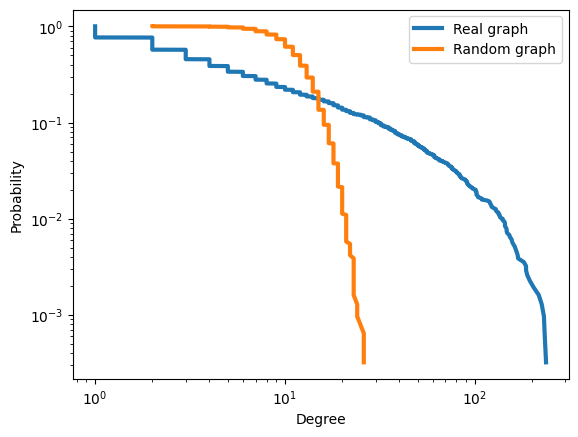

In [423]:
dataset = openflights
adjacency = dataset.adjacency
degrees = get_degrees(adjacency)

plot_loglog(degrees)

In [424]:
dataset = wikivitals
adjacency = dataset.adjacency

n = adjacency.shape[0]

in_degrees = adjacency.dot(np.ones(n))
out_degrees = adjacency.T.dot(np.ones(n))

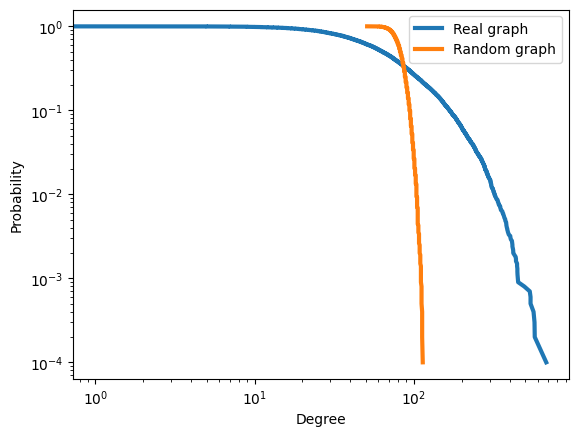

In [425]:
plot_loglog(in_degrees)

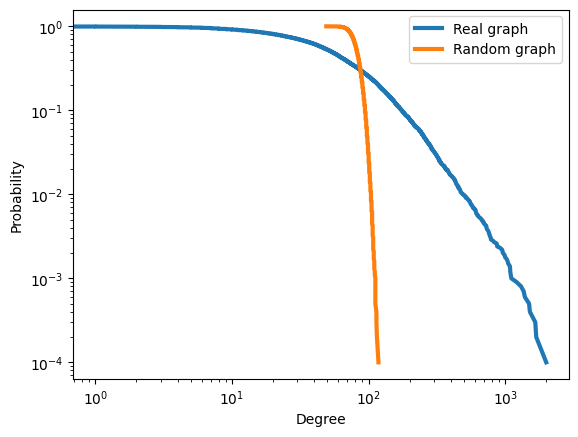

In [426]:
plot_loglog(out_degrees)

## 3. Small-world property


You will now make a few experiments highlighting the small-world property.


## To do

- Give a shortest path from [Plato](https://en.wikipedia.org/wiki/Plato) to [Platini](https://en.wikipedia.org/wiki/Michel_Platini) in WikiVitals.<br>
  List the corresponding articles.


In [427]:
dataset = wikivitals
adjacency = dataset.adjacency
names = dataset.names

In [428]:
source = np.flatnonzero(names == "Plato")[0]
destination = np.flatnonzero(names == "Michel Platini")[0]

shortest_path_tree = get_shortest_path(adjacency, source)

node = destination
path = [destination]

while node != source:
    node = get_neighbors(shortest_path_tree, node, transpose=True)[0]
    path = [node] + path

print(f"Distance between Plato and Michel Platini: {len(path) - 1}")
print(f"Path: {names[path]}")

Distance between Plato and Michel Platini: 3
Path: ['Plato' 'Naples' 'Diego Maradona' 'Michel Platini']


## To do

- Which fraction of the airports can be reached from **Paris Charles de Gaulle** in 1, 2, 3 flights?
- Which fraction of the articles can be reached from **Paris** in 1, 2, 3 clicks on Wikipedia Vitals?


In [429]:
dataset = openflights
adjacency = dataset.adjacency
names = dataset.names

In [430]:
source_name = "Charles de Gaulle International Airport"
source = np.flatnonzero(names == source_name)[0]

distances = get_distances(adjacency, source)
distances = distances[distances < 4]

for i in range(1, 4):
    idx = distances[distances <= i]
    print(f"Number of airports that can be reached at distance {i}: {len(idx)}")
    print(
        f"Fraction of airports that can be reached at distance {i}: {len(idx) / len(names):.3f}\n"
    )

Number of airports that can be reached at distance 1: 234
Fraction of airports that can be reached at distance 1: 0.076

Number of airports that can be reached at distance 2: 1917
Fraction of airports that can be reached at distance 2: 0.619

Number of airports that can be reached at distance 3: 2815
Fraction of airports that can be reached at distance 3: 0.909



In [431]:
dataset = wikivitals
adjacency = dataset.adjacency
names = dataset.names

In [432]:
source = np.flatnonzero(names == "Paris")[0]

distances = get_distances(adjacency, source)
distances = distances[distances < 4]

for i in range(1, 4):
    idx = distances[distances <= i]
    print(f"Number of articles that can be reached at distance {i}: {len(idx)}")
    print(
        f"Fraction of articles that can be reached at distance {i}: {len(idx) / len(names):.3f}\n"
    )

Number of articles that can be reached at distance 1: 426
Fraction of articles that can be reached at distance 1: 0.043

Number of articles that can be reached at distance 2: 6779
Fraction of articles that can be reached at distance 2: 0.677

Number of articles that can be reached at distance 3: 9974
Fraction of articles that can be reached at distance 3: 0.996



## To do

- Compute the [Bacon number](https://fr.wikipedia.org/wiki/Six_Degrees_of_Kevin_Bacon) of all actors (**without** building the co-starring actor graph).
- Plot the corresponding histogram.


In [433]:
dataset = cinema
# biadjacency matrix
biadjacency = dataset.biadjacency
movies = dataset.names_row
actors = dataset.names_col

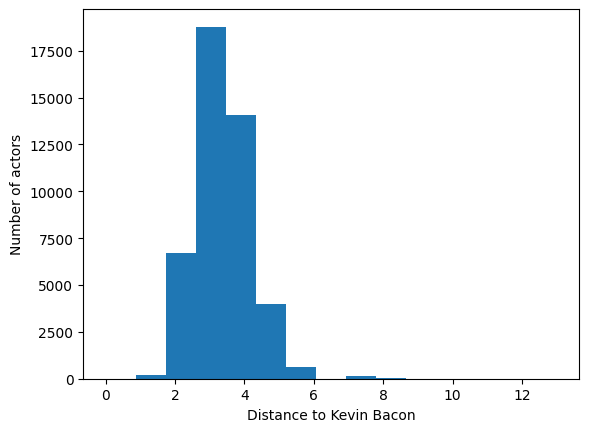

In [434]:
source = np.flatnonzero(actors == "Kevin Bacon")[0]

# biadjacency matrix, rows are movies and columns are actors
# A_ij = 1 if actor j plays in movie i
_, distances = get_distances(biadjacency, source_col=source)

# we divide by 2 because the distance is the number of movies between two actors (distance)
# A1 and A2 play in M1, A2 and A3 play in M2, the distance between A1 and A3 is 2
# this is because A1->M1->A2->M2->A3
bacon_numbers = distances // 2

plt.hist(bacon_numbers, bins=15)
plt.xlabel("Distance to Kevin Bacon")
plt.ylabel("Number of actors")
plt.show()

## 4. Clustering coefficient


Finally, we check the clustering property of real graphs (my friends tend to be friends).


## To do

- Compute the clustering coefficient of Openflights.
- Compare with that of a random graph of same size and same average degree.


In [435]:
dataset = openflights
adjacency = dataset.adjacency

In [436]:
get_clustering_coefficient(adjacency)

0.25107219520077

In [437]:
n = adjacency.shape[0]
adjacency_random = erdos_renyi(n, np.sum(adjacency.data) / n / (n - 1))

get_clustering_coefficient(adjacency_random)

0.0067314555215375795